In [1]:
!pip install mne # install mne
!pip install mat73 # install matlab version 7.3 loadmat
# librerias para sklearn SFS
# !pip install -U scikit-learn
# !pip install -U SciPy
# !pip install -U NumPy 
# !pip install -U Joblib
# !pip install -U threadpoolctl 

     |████████████████████████████████| 6.9 MB 18.9 MB/s 


# library

In [2]:
import os
import mne
import numpy as np
from numpy import angle, sin, cos, sqrt
# from scipy.io import loadmat
from mat73 import loadmat
import scipy as sp
from scipy.io import savemat
from scipy.signal import butter, lfilter, welch, hanning, filtfilt, hilbert
import matplotlib.pyplot as plt

# database

### Structure mne
### Average common reference

In [3]:

# path of database
path = '/content/drive/Shareddrives/GCPDS/databases/Music-EEG/'
# subjects of database
Subjects = list(range(1,21))

# save CAR
data_ref = list() 
y = []
for Subject in Subjects:
  # name of archive
  if Subject < 10:
    filename = f'music_listening_experiment_s0'+str(Subject)+'.mat'
  else:
    filename = f'music_listening_experiment_s'+str(Subject)+'.mat'
  data_ = loadmat(path+filename)

  # Create some dummy metadata
  n_channels = len(data_['sensor_info']['labels'])
  sampling_freq = data_['Fs'] # in Hertz
  ch_names = [data_['sensor_info']['labels'][n][0].upper() for n in range(n_channels)]
  y.append(data_['song_ratings'])

  for ch in range(n_channels):
    if ch_names[ch][0] == ' ':
      ch_names[ch] = ch_names[ch][1:]

  # structure 
  ch_types = ['eeg']*n_channels
  info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
  info.set_montage('standard_1020')
  raw = mne.EpochsArray(data_['EEG_Songs'], info)

  # CAR
  rereferenced_raw, ref_data = mne.set_eeg_reference(raw, ref_channels='average',projection=True,verbose=0)
  data_ref.append(rereferenced_raw.get_data())
y_ = np.asarray(y)

AssertionError: ignored

#  calculate-plot PSD

In [ ]:
# Calculate PSD
nblock = 256
overlap = 100
win = hanning(nblock, True)
data_power = []
for sub in range(len(Subjects)):
  Power = list()
  for tr in range(data_ref[sub].shape[0]):
    freqs, Pxxf = welch(np.squeeze(data_ref[sub][tr,:,:]), sampling_freq, window=win, noverlap=overlap, nfft=nblock, return_onesided=True)
    Power.append(Pxxf[:,2:90])
    # Power.append(Pxxf[:,16:61])
  data_power.append(np.asarray(Power))

Data_pow = np.asarray(data_power)
# savemat(path+'PSD.mat',{'Data_pow':Data_pow})

In [8]:
# dimensión de la PSD para todos los sujetos almacenados.
Data_pow.shape

(20, 30, 14, 88)

In [9]:
freqs[16:61]

array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. ,
       13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5,
       19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. ,
       24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5,
       30. ])

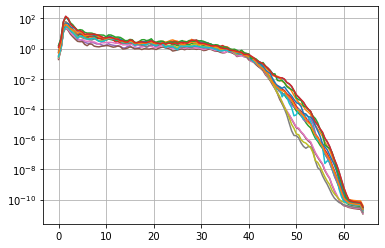

In [10]:
plt.semilogy(freqs, Pxxf.T)
plt.grid()
plt.show()

# Filter

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#filtering functions
def butter_bandpass(lowcut, highcut, fs, order=4):
  #lowcut is the lower bound of the frequency that we want to isolate
  #hicut is the upper bound of the frequency that we want to isolate
  #fs is the sampling rate of our data
  nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
  low = float(lowcut) / nyq
  high = float(highcut) / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

##
def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = filtfilt(b, a, mydata)
  return y

# PAC %estimation of phase-amplitude cross-frequency coupling

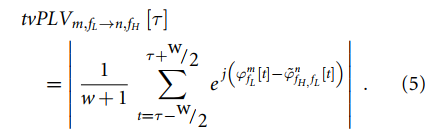

In [ ]:
def moving_multitrial_pac(data1,data2,fr1,fr2,Nsegments,sampling_freq,type):
  #calculating phase of theta
  phase_data = butter_bandpass_filter(data1, fr1[0], fr1[1],(sampling_freq))
  phase_data = angle(hilbert(phase_data))

  #calculating amplitude envelope of high gamma
  amp_data = butter_bandpass_filter(data2, fr2[0], fr2[1], (sampling_freq))
  amp_data = abs(hilbert(amp_data))

  # Filtering the amplitude of analytic signal of the high-frequency range within the
  # frequency range of the low-frequency band
  lowfromhigh = butter_bandpass_filter(amp_data, fr1[0], fr1[1],(sampling_freq))
  
  # lowfromhigh.shape
  low_Env_high_filtered_signals = lowfromhigh-np.tile(np.mean(lowfromhigh),(Ntrials,1))
  
  # get the phase
  Amp_phase_signals=angle(hilbert(low_Env_high_filtered_signals))
  Ntime = data1.shape[1]
  Nstep = np.floor(Ntime/Nsegments)
  if type == 'trials':
    temporal_ = np.zeros((Amp_phase_signals.shape[0],Nsegments))
  else:
    temporal_ = np.zeros((Nsegments))
  for ii in range(Nsegments): # repear over different segments
    start = np.floor((ii)*Nstep).astype(int)
    stop  = np.floor((ii+1)*Nstep).astype(int)
    if type == 'trials':
      plv = np.abs(np.sum(np.exp(1j*(phase_data[:,start:stop]-Amp_phase_signals[:,start:stop])),axis=1)/((Nstep)))
      temporal_[:,ii]=plv
    else:
      plv = np.abs(np.sum(np.sum(np.exp(1j*(phase_data[:,start:stop]-Amp_phase_signals[:,start:stop]))))/(Ntrials*(Nstep)))
      temporal_[ii]=plv
  return temporal_

In [ ]:
# Parameters
# Bands of rytms: delta to gamma.
phase_providing_band = [[1,4],[4,8],[8,10],[10,13],[13,20],[20,30],[30,45]] 
amplitude_providing_band = [[1,4],[4,8],[8,10],[10,13],[13,20],[20,30],[30,45]]
Ntrials   = data_ref[0].shape[0]
Nsegments = 8 # Number of segments in window.
Nchannels = data_ref[0].shape[1]
Nfreqs    = len(phase_providing_band)

In [ ]:
#@title Texto de título predeterminado
temporal_plv = np.zeros((len(Subjects),Ntrials,int(Nchannels*(Nchannels-1)/2),Nfreqs,Nfreqs,Nsegments))
# (Nodes,Nodes,Time)
for sub in range(len(Subjects)):
  cont_ch = 0 # contador de las subredes
  for ch1 in range(Nchannels):
    for ch2 in range(ch1+1,Nchannels-1):
      if ch1 != ch2:
        data1     = np.squeeze(data_ref[sub][:,ch1,:])
        data2     = np.squeeze(data_ref[sub][:,ch2,:])
        fr_1 = 0
        for fr1 in phase_providing_band:
          fr_2 = 0
          for fr2 in amplitude_providing_band:
            temporal_plv[sub,:,cont_ch,fr_1,fr_2,:] = moving_multitrial_pac(data1,data2,fr1,fr2,Nsegments,sampling_freq,type='trials')
            fr_2 += 1
          fr_1 += 1
      cont_ch += 1
  savemat(path+f'PLV_pac'+str(sub)+'_trials.mat',{'temporal_plv':temporal_plv})

In [ ]:
# PAC 
temporal_plv.shape
# np.transpose(temporal_plv, (0,4,1,2,3,5)).shape

(20, 30, 91, 1, 1, 8)

In [ ]:
temp.shape

(30,)

# Dinamic graph centrality measure

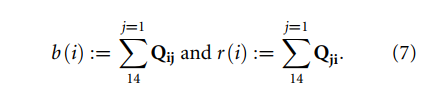

In [ ]:
## Contact Sequen
def arrayToContactSeq(adjArray,isdirected):
  # % arrayToContactSeq takes a sequence of matrices and converts this to a
  # % long format contact sequence.
  # %
  # % Inputs:
  # %       adjArray = an nNodes x nNodes x time-points array encoding a
  # %           dynamic network
  # %       isdirected = boolean indicating if the network is directed
  # %
  # % Output:
  # %       contactSequence = nEdges x 3 array of (i,j,t) tuples indicating
  # %           contact between nodes i,j at time t. If adjArray is weighted,
  # %           this will be an nEdges x 4 array of (i,j,t,w) including the
  # %           edge weight w.
  # % Reference: Ann E. Sizemore and Danielle S. Bassett, "Dynamic Graph 
  # % Metrics: Tutorial, Toolbox, and Tale." Submitted. (2017)
  nNodes = adjArray.shape[0]
  contactSequence = []
  for t in range(adjArray.shape[2]):
    if isdirected == 1:
      for i in range(nNodes):
        for j in range(i+1,nNodes):
          if adjArray[i,j,t] != 0:
              contactSequence.append([i, j, t, adjArray[i,j,t]])
    else:
      for i in range(nNodes):
        for j in range(i+1,nNodes):
          if i != j:
            if adjArray[i,j,t] != 0:
              contactSequence.append([i, j, t, adjArray[i,j,t]])
              
  contactSequence  = np.asarray(contactSequence)            
  # if it is unweighted, return only the first three columns
  if len(contactSequence.shape) != 1:
    if len(np.unique(contactSequence[:,3])) == 1:
      contactSequence = contactSequence[:,0:3]

  return contactSequence

## Networks
def networksFromContacts(contactSequence,directed):
  # % networksFromContacts creates an array of networks (weighted or binary)
  # % from a contact sequence.
  # %
  # % Input:
  # %       contactSequence = nEdges x 3 matrix encoding contacts between node
  # %           i,j at time t by (i,j,t). Optionally a fourth column denotes 
  # %           edge weight.
  # %       directed = 1 for creating a directed network, 0 otherwise.
  # %
  # % Output: 
  # %       adjArray = nNodes x nNodes x nTimes array describing binary or
  # %           weighted network at each time point.
  # % Reference: Ann E. Sizemore and Danielle S. Bassett, "Dynamic Graph 
  # % Metrics: Tutorial, Toolbox, and Tale." Submitted. (2017)
  times = np.unique(contactSequence[:,2])
  nNodes = np.unique([contactSequence[:,0], contactSequence[:,1]]).shape[0]
  adjArray = np.zeros((nNodes,nNodes,len(times)))

  if contactSequence.shape[1] == 3:
    edgeWeights = np.ones((contactSequence.shape[0],1))
  else:
    edgeWeights = contactSequence[:,3]
  
  for t in range(len(times)):
    edges = np.where(contactSequence[:,2] == times[t])[0]
    nodes = np.squeeze(contactSequence[edges,0:2]).astype(int)
    
    for i in range(nodes.shape[0]):
      if nodes.shape[0] == 1:
        adjArray[nodes[0],nodes[1],t] = edgeWeights[edges[i]]
        if not directed:
          adjArray[nodes[1],nodes[0],t] = edgeWeights[edges[i]]
      else:
        adjArray[nodes[i,0],nodes[i,1],t] = edgeWeights[edges[i]]
        if not directed:
          adjArray[nodes[i,1],nodes[i,0],t] = edgeWeights[edges[i]]

  return adjArray

## Threshold matrix at a given edge density.
def thresholdMatDensity(adj,density):
  # record and sort edges in decreasing order
  edges = np.concatenate(adj,axis=0)
  sortedEdges = np.flip(np.sort(edges))
  nEdges = len(edges)
  
  # Calculate threshold
  threshold = sortedEdges[int(np.ceil(nEdges*density))]

  # Threshold matrix
  tadj = adj
  tadj[tadj<threshold] = 0
  
  return tadj, threshold 

## Calculate the broadcast and receive centrality as defined in Mantzaris et al. 2013.
def broadcastRecieveCentrality(contactSequence,alpha, nNodes=None):
  # % Inputs:
  # %       contactSequence = nEdges x 3 array of (i,j,t) tuples indicating
  # %           contact between nodes i,j at time t. Assumes undirected.
  # %       alpha = scalar in (0,1) governing weight given to paths based on
  # %           the number of edges.
  # %
  # % Optional Inputs:
  # %       nNodes = number of nodes in the dynamic network. Default is all
  # %           nodes which appear in contactSequence (have at least one
  # %           contact).
  # %
  # % Outputs:
  # %       broadcastCentrality = nNodes x 1 vector recording the broadcast
  # %           centrality at each node.
  # %       receiveCentrality = nNodes x 1 vector recording the receive
  # %           centrality at each node.
  # %
  # % 
  # % Reference: Ann E. Sizemore and Danielle S. Bassett, "Dynamic Graph 
  # % Metrics: Tutorial, Toolbox, and Tale." Submitted. (2017)
  if nNodes == None:
    nNodes = np.unique([contactSequence[:,0], contactSequence[:,1]]).shape[0]
  
  # convert contact sequence to array of networks
  directed = 0
  adjArray = networksFromContacts(contactSequence,directed)
  badj = adjArray[:,:,0]
  badj[badj>0] = 1
  P_sd = np.linalg.inv(np.eye(nNodes) - alpha*badj)
  nTimes = adjArray.shape[2]
  
  for n in range(1,nTimes):
    [badj,threshold] = thresholdMatDensity(adjArray[:,:,n],0.1)
    badj[badj>0] = 1
    P_sd = P_sd.dot(np.linalg.inv(np.eye(nNodes) - alpha*badj))
  
  # # 
  Q_sd = P_sd/np.linalg.norm(P_sd);
  #
  broadcastCentrality = np.sum(Q_sd,axis=1).reshape(-1,1)
  receiveCentrality = np.sum(Q_sd,axis=0).reshape(1,-1)
  
  return broadcastCentrality,receiveCentrality

# Regression

In [17]:
# import required modules
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler

# clase para paralelizar
class Feats(BaseEstimator, TransformerMixin):
  def __init__(self):
    self

  def fit(self,X,*_):
    self.scaler = StandardScaler()
    Xfull = self.scaler.fit_transform(X)
    return Xfull

  def transform(self,X,*_):
    Xfull = self.scaler.transform(X)
    return Xfull

  def fit_transform(self,X,*_):
    self.fit(X)
    return self.transform(X)

class regress(BaseEstimator, RegressorMixin):
  def __init__(self,method='linear',n_features_to_select=20,C=0.1,gamma =0.1):
    self.n_features_to_select = n_features_to_select
    self.method = method
    self.C      = C
    self.gamma  = gamma

  def fit(self,X,y,*_):
    svrr = svm.SVR(kernel='linear')
    self.sfs_ = SFS(estimator= svrr,n_features_to_select=self.n_features_to_select)
    sfs = self.sfs_.fit_transform(X,y)
    self.svrr = svm.SVR(kernel='linear',C=self.C,gamma=self.gamma).fit(sfs,y)
    return self.svrr

  def predict(self,X,*_):
    sfs = self.sfs_.transform(X)
    return self.svrr.predict(sfs)

  def fit_predict(self,X,y,*_):
    self.fit(X,y)
    return self.predict(X)

In [ ]:
steps = [('Feats', Feats()), 
          ('Reg', regress())]
pipe_svr = Pipeline(steps)

In [ ]:
pipe_svr.fit(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('Feats', Feats()), ('Reg', regress())])

## regression con PSD


In [18]:
sub = 0
dat = np.squeeze(Data_pow[sub,:,:,:])
X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))

In [19]:
X.shape

(30, 1232)

In [20]:
#this one to prevent warning about gamma settings
# import required modules
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.svm import LinearSVR,SVR
# data loading scaling, splitting
# validation subject
best_ = list()
results_ = list()
for sub in range(len(Subjects)):
  scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
  # 30 trials donde se realiza una pertición de 3 grupos iguales, donde los dos primeros
  # se utilizaron para entrenamiento y el último de validación 
  # clases de la base de datos.
  y = y_[sub,:].reshape(-1,1)
  # PSD.
  dat = np.squeeze(Data_pow[sub,:,:,:])
  X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  # PAC in the time.
  # dat = np.squeeze()
  # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  # Grid_s = list()
  # for i in range(50):
    # print(f'fold '+str(i))
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=0)
  shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)
  steps = [('Reg', SVR(kernel='rbf'))]
  pipe_svr = Pipeline(steps)
  params_grid={
            'Reg__C': [0.01, 1, 10, 100, 1000],
            'Reg__gamma':[0.01, 1, 10, 100, 1000]
            }

  grid = GridSearchCV(estimator=pipe_svr, 
                    param_grid=params_grid, 
                    scoring=scorer,
                    cv =shuffle_split, # cv = 5 0 cv = 10
                    error_score='raise',
                    verbose=20)

  grid.fit(X,y.ravel())
  results_.append(grid.cv_results_)
  best_.append(grid.best_estimator_)
  # grid.
  # Grid_s.append(grid.fit(X,y))

Se han truncado las últimas 5000 líneas del flujo de salida.
[CV 5/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=3.657 total time=   0.0s
[CV 6/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01..............................
[CV 6/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=2.667 total time=   0.0s
[CV 7/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01..............................
[CV 7/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=3.166 total time=   0.0s
[CV 8/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01..............................
[CV 8/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=2.667 total time=   0.0s
[CV 9/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01..............................
[CV 9/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=2.667 total time=   0.0s
[CV 10/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01.............................
[CV 10/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=3.166 total time=   0.0s
[CV 1/10; 2/25] START Reg__C=0.01, Reg__g

In [21]:
MAE = list()
R2  = list()
mae_subs = list()
r2_subs = list()
for sub in range(len(best_)):
  dat = np.squeeze(Data_pow[sub,:,:,:])
  X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))

  for train_index, test_index in shuffle_split.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
    y_pred = best_[sub].predict(X[test_index,:])
    y_true = y[test_index]
    mae    = mean_absolute_error(y_true,y_pred)
    r2     = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
    # print('MAE es {mae}, y R2 es {r2}'.format(mae=mae,r2=r2))

  mae_m = np.mean(MAE)
  r2_m  = np.mean(R2)
  mae_subs.append(mae_m)
  r2_subs.append(r2_m)
  print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub,mae=mae_m,r2=r2_m))
# print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(mae_subs),r2=np.mean(r2_subs)))

Sujeto 0: Promedio MAE es 1.6888888888888889, y R2 es -0.5799764080006015
Sujeto 1: Promedio MAE es 1.6602771304478587, y R2 es -0.5639799033085096
Sujeto 2: Promedio MAE es 1.61944143833694, y R2 es -0.48668117225019
Sujeto 3: Promedio MAE es 1.6173588565304828, y R2 es -0.48686514219613936
Sujeto 4: Promedio MAE es 1.631664863002164, y R2 es -0.5421458377211192
Sujeto 5: Promedio MAE es 1.6134244502939183, y R2 es -0.5287775133186232
Sujeto 6: Promedio MAE es 1.5892844494582787, y R2 es -0.47534902353287806
Sujeto 7: Promedio MAE es 1.5711794488315494, y R2 es -0.4398690787159393
Sujeto 8: Promedio MAE es 1.5521595100724888, y R2 es -0.4094273568835268
Sujeto 9: Promedio MAE es 1.5480546701763507, y R2 es -0.4246421330381699
Sujeto 10: Promedio MAE es 1.5376254577405126, y R2 es -0.41376911300419755
Sujeto 11: Promedio MAE es 1.5381937066325067, y R2 es -0.41151013326359787
Sujeto 12: Promedio MAE es 1.5429480368915445, y R2 es -0.41869688234089925
Sujeto 13: Promedio MAE es 1.539883

## regress con PAC

In [ ]:
# ArrayToContactSeq takes a sequence of matrices and converts this to a
from scipy.io import loadmat
aa = loadmat(path+f'PLV_pac'+str(sub)+'_trials.mat')
temporal_plv = aa['temporal_plv']
alpha = 0.1
broadcastCentrality_sub = []
receiveCentrality_sub = []
# load(path+f'PLV_pac19.mat')
for sub in range(len(Subjects)):
  broadcastCentrality = []
  receiveCentrality = []
  for tr in range(temporal_plv.shape[1]): 
    temp1,temp2 = [],[]
    for cont_ch in range(temporal_plv.shape[2]):
      # long format contact sequence.
      contactSequence = arrayToContactSeq(temporal_plv[sub,tr,cont_ch,:,:,:],0)
      if len(contactSequence.shape) != 1:
        [broad,receive] = broadcastRecieveCentrality(contactSequence,alpha)
      temp1.append(broad)
      temp2.append(receive.T)
    broadcastCentrality.append(temp1)
    receiveCentrality.append(temp2)
  broadcastCentrality_sub.append(np.asarray(broadcastCentrality))
  receiveCentrality_sub.append(np.asarray(receiveCentrality))
broadcastCentrality_ = np.asarray(broadcastCentrality_sub)
receiveCentrality_  = np.asarray(receiveCentrality_sub)

In [13]:
X.shape

NameError: ignored

In [183]:
#this one to prevent warning about gamma settings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
# import required modules
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR,SVR
# data loading scaling, splitting
# validation subject
results_ = []
best_ = []
for sub in range(len(Subjects)):
  scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
  # 30 trials donde se realiza una pertición de 3 grupos iguales, donde los dos primeros
  # se utilizaron para entrenamiento y el último de validación 
  # clases de la base de datos.
  y = y_[sub,:].reshape(-1,1)
  # PAC in the time.
  dat = np.squeeze(np.concatenate([broadcastCentrality_,receiveCentrality_],axis=4)[sub,:,:,:,:])
  X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]*dat.shape[3]))

  # dat = np.squeeze(broadcastCentrality_[sub,:,:,:,:])
  # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  
  # dat = np.squeeze()
  # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  # Grid_s = list()
  # for i in range(50):
    # print(f'fold '+str(i))
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=0)
  shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)
  steps = [('Scaler',StandardScaler()),
           ('Reg', SVR(kernel='rbf'))]
  pipe_svr = Pipeline(steps)
  params_grid={
            'Reg__C': [0.01, 1, 10, 100, 1000],
            'Reg__gamma':[0.01, 1, 10, 100, 1000]
            }

  grid = GridSearchCV(estimator=pipe_svr, 
                    param_grid=params_grid, 
                    scoring=scorer,
                    cv = shuffle_split,
                    error_score='raise',
                    verbose=20)

  
  grid.fit(X,y.ravel()) # X_train,y_train
  y_est[sub] = grid.predict(X_test)
  results_.append(grid.cv_results_)
  best_.append(grid.best_estimator_)

Se han truncado las últimas 5000 líneas del flujo de salida.
[CV 5/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=3.654 total time=   0.0s
[CV 6/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01..............................
[CV 6/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=2.667 total time=   0.0s
[CV 7/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01..............................
[CV 7/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=3.166 total time=   0.0s
[CV 8/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01..............................
[CV 8/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=2.667 total time=   0.0s
[CV 9/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01..............................
[CV 9/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=2.667 total time=   0.0s
[CV 10/10; 1/25] START Reg__C=0.01, Reg__gamma=0.01.............................
[CV 10/10; 1/25] END Reg__C=0.01, Reg__gamma=0.01;, score=3.166 total time=   0.0s
[CV 1/10; 2/25] START Reg__C=0.01, Reg__g

In [184]:
mae_subs = list()
r2_subs = list()
MAE = list()
R2  = list()
for sub in range(len(best_)):
  # dat = np.squeeze(broadcastCentrality_[sub,:,:,:,:])
  # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  dat = np.squeeze(np.concatenate([broadcastCentrality_,receiveCentrality_],axis=4)[sub,:,:,:,:])
  X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]*dat.shape[3]))

  for train_index, test_index in shuffle_split.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
      y_pred = best_[sub].predict(X[test_index,:])
      y_true = y[test_index]
      mae    = mean_absolute_error(y_true,y_pred)
      r2     = r2_score(y_true,y_pred)
      MAE.append(mae)
      R2.append(r2)
      # print('MAE es {mae}, y R2 es {r2}'.format(mae=mae,r2=r2))

  mae_m = np.mean(MAE)
  r2_m  = np.mean(R2)
  mae_subs.append(mae_m)
  r2_subs.append(r2_m)
  # print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub,mae=mae_m,r2=np.abs(r2_m)))
print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(mae_subs),r2=np.abs(np.mean(r2_subs))))

Sujetos: Promedio MAE es 1.3426189483174775, y R2 es 0.17039589366568283


# leave subject out 
## PSD

In [11]:
#this one to prevent warning about gamma settings
# import required modules
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
Svr_m = []
Svr_  = []
from sklearn.svm import LinearSVR,SVR
# data loading scaling, splitting
# validation subject
best_ = list()
results_ = list()

scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
  # 30 trials donde se realiza una pertición de 3 grupos iguales, donde los dos primeros
  # se utilizaron para entrenamiento y el último de validación 
  # clases de la base de datos.
Subjects = list(range(1,21))
for sub_test in Subjects:
  Subjects_train= Subjects[:]
  Subjects_train.pop(Subjects_train.index(sub_test))
  y_tr = list()
  X_tr = list()
  for sub in Subjects_train:
    y_tr.append(y_[sub-1,:].reshape(-1,1))
    dat = np.squeeze(Data_pow[sub-1,:,:,:])
    X_tr.append(np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2])))
  X_tr = np.concatenate(X_tr,axis=0)
  dat  = np.squeeze(Data_pow[sub_test-1,:,:,:])
  X_te = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  y_tr = np.concatenate(y_tr,axis=0)
  y_te = y_[sub_test-1,:].reshape(-1,1)

  params_grid={
            'C': [0.01, 1, 10, 100, 1000],
            'gamma':[0.01, 1, 10, 100, 1000]
            }
  grid = ParameterGrid(params_grid)
  svr_  = []
  svr_m = []
  for params in grid:
    svr_t = SVR(kernel='rbf',**params).fit(X_tr,y_tr.reshape(-1))
    svr_.append(svr_t.predict(X_te))
    svr_m.append(svr_t)
  Svr_m.append(svr_m)
  Svr_.append(svr_)

In [12]:
mae_subs = list()
r2_subs = list()
MAE = list()
R2  = list()
for sub in range(len(Svr_)):
  # dat = np.squeeze(Data_pow[sub,:,:,:])
  # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  # for train_index, test_index in shuffle_split.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
  pos = 0

  for params in grid:
    y_pred =  Svr_[sub][pos]
    pos+=1
    y_true = y_[sub,:].reshape(-1,1)
    mae    = mean_absolute_error(y_true,y_pred.reshape(-1,1))
    r2     = r2_score(y_true,y_pred)
    MAE.append(mae)
    R2.append(r2)
#     # print('MAE es {mae}, y R2 es {r2}'.format(mae=mae,r2=r2))
  # mae_m = np.mean(MAE)
  # r2_m  = np.mean(R2)
  mae_subs.append(MAE)
  r2_subs.append(R2)
#   # print('Sujeto {sub}: Promedio MAE es {mae}, y R2 es {r2}'.format(sub=sub,mae=mae_m,r2=r2_m))
# print('Sujetos: Promedio MAE es {mae}, y R2 es {r2}'.format(mae=np.mean(mae_subs),r2=np.mean(r2_subs)))

In [ ]:
r2_subs

## PAC

In [ ]:
#this one to prevent warning about gamma settings
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
# import required modules
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, preprocessing
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR,SVR
# data loading scaling, splitting
# validation subject
results_ = []
best_ = []
for sub in range(len(Subjects)):
  scorer = make_scorer(mean_squared_error)#, greater_is_better=False)
  # 30 trials donde se realiza una pertición de 3 grupos iguales, donde los dos primeros
  # se utilizaron para entrenamiento y el último de validación 
  # clases de la base de datos.
  y = y_[sub,:].reshape(-1,1)
  # PAC in the time.
  dat = np.squeeze(np.concatenate([broadcastCentrality_,receiveCentrality_],axis=4)[sub,:,2:7,2:7,:])
  X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]*dat.shape[3]))

  # dat = np.squeeze(broadcastCentrality_[sub,:,:,:,:])
  # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  
  # dat = np.squeeze()
  # X = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
  # Grid_s = list()
  # for i in range(50):
    # print(f'fold '+str(i))
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=0)
  shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)
  steps = [('Reg', SVR(kernel='rbf'))]
  pipe_svr = Pipeline(steps)
  params_grid={
            'Reg__C': [0.01, 1, 10, 100, 1000],
            'Reg__gamma':[0.01, 1, 10, 100, 1000]
            }

  grid = GridSearchCV(estimator=pipe_svr, 
                    param_grid=params_grid, 
                    scoring=scorer,
                    cv =shuffle_split,
                    error_score='raise',
                    verbose=20)

  grid.fit(X,y.ravel())
  results_.append(grid.cv_results_)
  best_.append(grid.best_estimator_)

# others

In [ ]:
import numpy as np
from sklearn.model_selection import ShuffleSplit
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [3, 4], [5, 6]])
y = np.array([1, 2, 1, 2, 1, 2])
rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
rs.get_n_splits(X)

print(rs)

for train_index, test_index in rs.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None)
TRAIN: [1 3 0 4] TEST: [5 2]
TRAIN: [4 0 2 5] TEST: [1 3]
TRAIN: [1 2 4 0] TEST: [3 5]
TRAIN: [3 4 1 0] TEST: [5 2]
TRAIN: [3 5 1 0] TEST: [2 4]


In [ ]:
# print the best parameters from all possible combinations
print("best parameters are: ", grid.best_params_)

best parameters are:  {'Reg__C': 0.001, 'Reg__gamma': 0.001, 'Reg__n_features_to_select': 15}


In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score
mean_absolute_error(y_test, y_pred)

1.4603729164744272

In [ ]:
abs(r2_score(y_test, y_pred))

0.20013585182893978

In [ ]:
# getting out the info I want
    # for i in range(len(sfs.cv_results_['params'])):
    #     print(sfs.cv_results_['params'][i], 'test acc.:', sfs.cv_results_['mean_test_score'][i])

#####        
#let's look at a small chunk of our data
# # figure(figsize = (15,6))
# plt.plot((data[1:int(sampling_freq)*2]-np.mean(data[1:int(sampling_freq)*2]))/np.std(data[1:int(sampling_freq)*2]),label= 'Raw Data'); #normalized raw data
# plt.plot(phase_data[1:int(sampling_freq)*2],label= 'Phase of Theta');
# plt.plot(amp_data[1:int(sampling_freq)*2],label= 'Amplitude of High Gamma'); 
# # xlabel('Two Seconds of Theta Phase and High Gamma Amplitude')
# # legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

In [ ]:
# def circCorr(ang,line):
#   n = len(ang)
#   rxs = sp.stats.pearsonr(line,sin(ang))
#   rxs = rxs[0]
#   rxc = sp.stats.pearsonr(line,cos(ang))
#   rxc = rxc[0]
#   rcs = sp.stats.pearsonr(sin(ang),cos(ang))
#   rcs = rcs[0]
#   rho = sqrt((rxc**2 + rxs**2 - 2*rxc*rxs*rcs)/(1-rcs**2)) #r
#   r_2 = rho**2 #r squared
#   pval = 1- sp.stats.chi2.cdf(n*(rho**2),1)
#   standard_error = sqrt((1-r_2)/(n-2))

#   return rho, pval, r_2,standard_error

# print(circCorr(phase_data, amp_data))

In [ ]:
# import required modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn import svm, preprocessing

# data loading scaling, splitting
url= 'https://raw.githubusercontent.com/mycarta/Data-science-tools-petroleum-exploration-and-production/master/Python/data/Table2_Hunt_2013_edit.csv'
data = pd.read_csv(url).astype('float64')
y =  data['Production']
X = data.drop('Production',axis=1)
scaled_X = preprocessing.StandardScaler().fit_transform(X)
scaled_X_df = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)
train_X, val_X, train_y, val_y = train_test_split(scaled_X_df, y, test_size= 0.2, random_state=99)

# set-up scoring and crossvalidation 
scorer = make_scorer(mean_squared_error, greater_is_better=False)
loo = LeaveOneOut()

#this one to prevent warning about gamma settings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# pipeline
svrr = svm.SVR()

sfs = SFS(estimator=svrr, 
          n_features_to_select=1)

pipe = Pipeline([('sfs', sfs), 
                 ('svr', svrr)])

parm_grid=[
    {
     'svr__gamma':[0.0005, 0.0002, 0.0001, 0.001, 0.01, 0.1, 1, 2]}
    ]

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=parm_grid,
                           scoring=scorer,
                           cv=loo)

sfs = grid_search.fit(train_X, train_y)

dat = sfs.predict(val_X)
# # getting out the info I want
# for i in range(len(sfs.cv_results_['params'])):
#     print(sfs.cv_results_['params'][i], 'test acc.:', sfs.cv_results_['mean_test_score'][i])

In [ ]:
dat

array([29.82363356, 23.53982307, 32.26090374, 32.5211305 , 29.57679224])

# section 2

In [ ]:
from __future__ import division
import numpy as np
import math
from scipy.signal import filtfilt, firwin2, freqz, hilbert
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, fixed
from IPython.display import display

In [ ]:
def power_two(n):
    '''
    Calculate the next power of 2 above the number provided
    '''
    return 2**(int(math.log(n, 2))+1)


def fasthilbert(x, axis=-1):
    '''
    Redefinition of scipy.signal.hilbert, which is very slow for some lengths
    of the signal x. This version zero-pads the signal to the next power of 2
    for speed.
    '''
    x = np.array(x)
    N = x.shape[axis]
    N2 = power_two(len(x))
    Xf = np.fft.fft(x, N2, axis=axis)
    h = np.zeros(N2)
    h[0] = 1
    h[1:(N2 + 1) // 2] = 2
        
    x = np.fft.ifft(Xf * h, axis=axis)
    return x[:N]

def rmv_edge(x,win):
    '''
    Remove the edge effects from a filtered signal
    '''
    return x[np.int(win):-np.int(win)]

def pacpretty(beta_center_freq,beta_bandwidth,beta_transition,beta_cycles,
              gamma_center_freq,gamma_bandwidth,gamma_transition,gamma_cycles):
    '''
    Same as PAC function but only with long variable names of interest
    '''
    data=np.load('./exampledata.npy')
    pac(data,beta_center_freq,beta_bandwidth,gamma_center_freq,gamma_bandwidth,
        beta_cycles,beta_transition,gamma_cycles,gamma_transition)

In [ ]:
def pac(x, bcf = 21.5, bbw = 17, gcf = 140, gbw = 60,
        bcy = 5, btw = .15, gcy = .5, gtw = .15,
        gcy_g = False, Fs = 1000):
    '''
    Calculate phase-amplitude coupling
    
    Parameters
    ----------
    x : array
        temporal signal
    bcf : float
        center frequency of the low frequency band
    bbw : float
        bandwidth of the low frequency band
    gcf : float
        center frequency of the high frequency band
    gbw : float
        bandwidth of the high frequency band
    bcy : float
        width of filtering window of the low frequency band in terms of the 
        number of cycles of the center frequency of that band
    btw : float (0<x<1)
        transition width of the low frequency band filter as a fraction of
        the frequencies of the passband
    gcy : float
        width of filtering window of the high frequency band in terms of the 
        number of cycles of the center frequency of that band or the beta band
        (depending on gcy_g value)
    gtw : float (0<x<1)
        transition width of the high frequency band filter as a fraction of
        the frequencies of the passband
    gcy_g : boolean
        True : the width of the high frequency band filter is measured as the 
        number of cycles of the center frequency in the high frequency band
        False : the width of the high frequency band filter is measured as the 
        number of cycles of the center frequency in the low frequency band 
    Fs : integer
        sampling rate
  
    Returns
    -------
    amp : array
        Time series of the analytic amplitude of the upper frequency band
    pha : array
        Time series of the analytic phase of the lower frequency band
    pac : numeric
        PAC value
    and now other things
    '''
    
    # Process parameters
    flo = (bcf - bbw / 2.0, bcf + bbw / 2.0)
    fhi = (gcf - gbw / 2.0, gcf + gbw / 2.0)
    nyq = Fs/2
    
    # Beta filter
    Ntapsb = np.floor(bcy*Fs/bcf)
    f = [0, (1-btw)*flo[0]/nyq, flo[0]/nyq, flo[1]/nyq, (1+btw)*flo[1]/nyq, 1]
    m = [0,0,1,1,0,0]
    tapsb = firwin2(Ntapsb, f, m)
    xb = filtfilt(tapsb,[1],x)
    
    # Gamma filter
    if gcy_g:
        Ntapsg = np.floor(gcy*Fs/gcf)
    else:
        Ntapsg = np.floor(gcy*Fs/bcf)
    f = [0, (1-gtw)*fhi[0]/nyq, fhi[0]/nyq, fhi[1]/nyq, (1+gtw)*fhi[1]/nyq, 1]
    m = [0,0,1,1,0,0]
    tapsg = firwin2(Ntapsg, f, m)
    xg = filtfilt(tapsg,[1],x)
    xb = rmv_edge(xb,np.ceil(np.max([Ntapsb,Ntapsg])/2.0))
    xg = rmv_edge(xg,np.ceil(np.max([Ntapsb,Ntapsg])/2.0))
    
    # Frequency responses
    [wb,hb] = freqz(tapsb)
    wb = wb*nyq/np.pi
    [wg,hg] = freqz(tapsg)
    wg = wg*nyq/np.pi
    
    # Analytic amplitude and phase time signals
    amp = np.abs(fasthilbert(xg))
    pha = np.angle(fasthilbert(xb))
    phadeg = np.degrees(pha)
    
    # Calculate PAC: modulation index (Tort, 2008)
    bin_phase_lo = np.arange(-180,180,20)
    binned_meanA = np.zeros(len(bin_phase_lo))
    for b in range(len(bin_phase_lo)):
        phaserange = np.logical_and(phadeg>=bin_phase_lo[b],phadeg<(bin_phase_lo[b]+20))
        binned_meanA[b] = np.mean(amp[phaserange])
        
    p_j = np.zeros(len(bin_phase_lo))
    for b in range(len(bin_phase_lo)):
        p_j[b] = binned_meanA[b]/sum(binned_meanA)
        
    H = -sum(np.multiply(p_j,np.log10(p_j)))
    Hmax = np.log10(18)
    pac_mi = (Hmax-H)/Hmax
        
    # Calculate PAC: phase-locking value (Tort, 2010)
    amp_beta = filtfilt(tapsb,[1],amp)
    amp_pha = np.angle(fasthilbert(amp_beta))
    pac_plv = np.abs(np.sum(np.exp(1j * (pha - amp_pha)))) / len(pha)
    
    makeplots(amp, pha, pac_mi, tapsb, tapsg, wb, hb, wg, hg, bin_phase_lo, binned_meanA, pac_plv)
    
    return

In [ ]:
def makeplots(amp, pha, pac_mi, tapsb, tapsg, wb, hb, wg, hg, bin_phase_lo, binned_meanA, pac_plv):
    '''
    Make plots: 
    1. Beta filter impulse response
    2. Beta filter frequency response
    3. Gamma filter impulse response
    4. Gamma filter frequency response
    5. Histogram of gamma power over beta cycle
    '''
    
    Ntapsb = len(tapsb)
    Ntapsg = len(tapsg)
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,3,1)
    plt.cla()
    plt.plot(tapsb)
    plt.ylabel('Beta impulse response')
    plt.annotate('Window length: '+np.str(np.int(Ntapsb)),
                xy=(.02, .9),  xycoords='axes fraction')  
    
    plt.subplot(2,3,2)
    plt.cla()
    plt.plot(wb,abs(hb))
    plt.xlim([0,50])
    plt.ylim([0,1.05])
    plt.ylabel('Amplitude (dB)')
    
    plt.subplot(2,3,4)
    plt.cla()
    plt.plot(tapsg)
    plt.xlabel('samples (ms)')
    plt.ylabel('Gamma impulse response')
    plt.annotate('Window length: '+np.str(np.int(Ntapsg)),
                xy=(.02, .9),  xycoords='axes fraction') 
    plt.subplot(2,3,5)
    plt.cla()
    plt.plot(wg,abs(hg))
    plt.ylim([0,1.05])
    plt.xlim([0,300])
    plt.xlabel('f (Hz)')
    plt.ylabel('Amplitude (dB)')
    
    plt.subplot(1,3,3)
    plt.cla()
    plt.bar(bin_phase_lo,binned_meanA,20)
    plt.ylabel('Mean gamma power')
    plt.xlabel('Beta phase (degrees)')
    plt.xlim([-180,180])
    plt.xticks(np.arange(-180,181,60))
    plt.annotate('\nMI = '+np.str(np.round(pac_mi,4))+'\nPLV = '+np.str(np.round(pac_plv,2)),
                xy=(.02, .9),  xycoords='axes fraction')  
    plt.show()
    
    return

In [ ]:
w=interactive(pacpretty,
              beta_center_freq = FloatSlider(min = 12, max = 30, step = 0.5, value = 21.5),
              beta_bandwidth = FloatSlider(min = 1, max = 20, step = 1, value = 17),
              beta_transition = FloatSlider(min = 0.05, max = 0.95, step = 0.05, value = 0.15),
              beta_cycles = FloatSlider(min = 2, max = 10, step = 1, value = 5),
              gamma_center_freq = FloatSlider(min = 50, max = 200, step = 10, value = 140),
              gamma_bandwidth = FloatSlider(min = 10, max = 100, step = 10, value = 60),
              gamma_transition = FloatSlider(min = 0.05, max = 0.95, step = 0.05, value = 0.15),
              gamma_cycles = FloatSlider(min = 0.5, max = 10, step = 0.5, value = 0.5))
display(w)